## Chap 09. Policy Gradient

---- 

conda env : [rl_learning](./README.md#setup-a-conda-environment)



- Value based Method : State-Value or Action-Value(Q function)
    - Monte Carlo
    - SARSA
    - Q-Learning

- Policy grdient


### Chap 9.1 Simple Policy Gradient

- Probabilistic policy: $\pi(a|s)$
- Neural network of probabilistic policy : $\pi_{\theta}(a|s)$

- Target function (Object function) of $\pi_{\theta}(a|s)$
    - Episodic task
    - Trajectory: $τ = (S_0, A_0, R_0, S_1, A_1, R_1, ..., S_{T+1})$
    - Gain: $G(\tau) = R_0 + \gamma R_1 + \gamma^2 R_2 + ... + \gamma^T R_T$
    - Object function: $J(θ) = E_{\tau   \pi_{θ}}[G(\tau)]$
    - Gradient of Object function:
        - $ \nabla_{\theta}J(\theta) = \nabla_{\theta}E_{\tau   \pi_{θ}}[G(\tau)]$
        - $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{\tau}G(\tau)\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ .... (**Eq 9.1**)
    - Optimization ov nerual network
        - $\theta \leftarrow \theta + \alpha \nabla_{\theta}J(\theta)$

- Policy Gradient:
    - Apply Monte Carlo Sampling on **Eq 9.1**
        - Sampling : $\tau^{(i)} -   \pi_{\theta} $
        - $x^{i} = \sum\limits_{t=0}^{\tau^{i}}G(\tau)\nabla_{\theta} log \pi_{\theta}(A_t^{i}|S_t^{i})$
        - $\nabla_{\theta}J(\theta) ≈ \frac{x^{1} + x^{2} + ... + x^{n}}{n}$
    - When $n = 1$
        - Sampling : $\tau -   \pi_{\theta} $
        - $\nabla_{\theta}J(\theta) ≈ \sum\limits_{t=0}^{\tau}G(\tau)\nabla_{\theta} log \pi_{\theta}(A_t|S_t)$
        - $\nabla_{\theta} log \pi_{\theta}(A_t|S_t) = \frac{\nabla_{\theta}\pi_{\theta}(A_t|S_t)}{\pi_{\theta}(A_t|S_t)}$
        - $\nabla_{\theta} log \pi_{\theta}(A_t|S_t)$ : vector
        - $\nabla_{\theta}\pi_{\theta}(A_t|S_t)$ : vector
        - $\frac{1}{\pi_{\theta}(A_t|S_t)}$ : Scalar
        - $G(\tau)$ : Scalar

### Chap 9.1.3 Policy gradient Implemetation - 1

In [2]:
# @title Chap 9.1.3 Policy gradient Implemetation - 1
import numpy as np
import gymnasium as gym
import renderlab as rl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


class Policy(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x

class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.lr)

    def get_action(self, state):
        state = torch.tensor(state[np.newaxis, :])
        probs = self.pi(state)
        probs = probs[0]
        m = Categorical(probs)     ##
        action = m.sample().item() ##
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, prob in self.memory:
            loss += - torch.log(prob) * G

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory = []


env = gym.make('CartPole-v1', render_mode = "rgb_array")
state = env.reset()[0]
agent = Agent()

action, prob = agent.get_action(state)
print(f"action : {action}")
print(f"prob: {prob}")

G = 100.0 # dummy
J = G*torch.log(prob)
print(f"J : {J}")
J.backward()

action : 1
prob: 0.5057163834571838
J : -68.17792510986328


### Chap 9.1.3 Policy gradient Implemetation-2

In [ ]:
# @title Chap 9.1.3 Policy gradient Implemetation-2
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1', render_mode = "rgb_array")
env = rl.RenderFrame(env, "./temp_output")
agent = Agent()
reward_history = []

for episode in range(3000):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated
        agent.add(reward, prob)
        state = next_state
        total_reward += reward

    agent.update() # Episodic task : End of Episode

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))

# plt.xlabel('episode')
# plt.ylabel('loss')
# plt.plot(range(len(reward_history)), reward_history)
# plt.show()

# env.play()

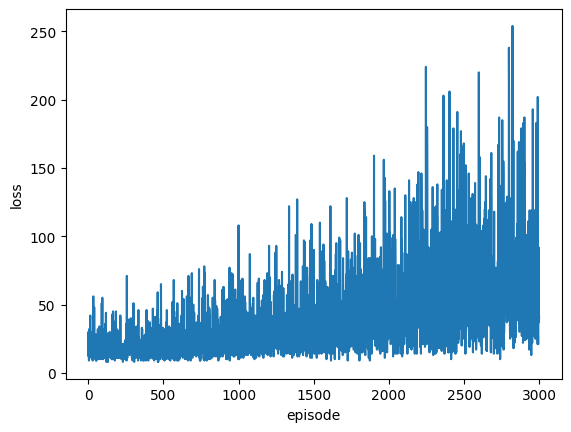

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [8]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(reward_history)), reward_history)
plt.show()

env.play()

### Chap 9.2 REINFORCE

REINFORCE : **Re**ward **I**ncrement = **N**onnegative **F**actor x **O**ffset **R**einforcement x **C**haracterisitic **E**ligibility

- $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{\tau}G(\tau)\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ ... **[Eq 9.1]**

REINFORCE: Consider $G_t$
- $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{\tau}G_t\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ ... **[Eq 9.3]**
- $G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + ... + \gamma^{T-t} R_{T}$

In [ ]:
# @title Chap 9.2.2 REINFORCE Implementation

import numpy as np
import gymnasium as gym
import renderlab as rl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


class Policy(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x

class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.lr)

    def get_action(self, state):
        state = torch.tensor(state[np.newaxis, :])
        probs = self.pi(state)
        probs = probs[0]
        m = Categorical(probs)     ##
        action = m.sample().item() ##
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G
            loss += - torch.log(prob) * G

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory = []

import matplotlib.pyplot as plt

env = gym.make('CartPole-v1', render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
agent = Agent()
reward_history = []

for episode in range(3000):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated
        agent.add(reward, prob)
        state = next_state
        total_reward += reward

    agent.update() # Episodic task : End of Episode

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))

# plt.xlabel('episode')
# plt.ylabel('loss')
# plt.plot(range(len(reward_history)), reward_history)
# plt.show()

# env.play()

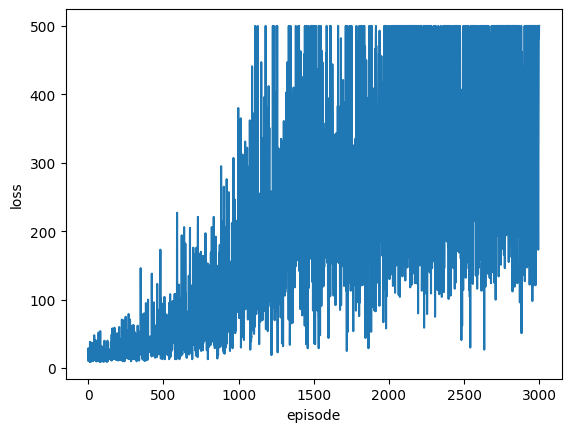

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [10]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(reward_history)), reward_history)
plt.show()

env.play()

### Chap 9.3. BaseLine

REINFORCE:
- $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{T}G_t\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ ... **[Eq 9.3]**

BaseLine
- $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{T}\big(G_t - b(S_t) \big)\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ ... **[Eq 9.4]**
- $b(S_t)$ : Any function whick takes $S_t$ as an input.
- Compared to REINFORCE:
    - Reduce variance Gain from different policy
    - More efficient training

### Cahp 9.4 Actor-Critic

REINFORCE with baseline
- $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{T}\big(G_t - b(S_t) \big)\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ ... **[Eq 9.4]**
    - $G_t$ : Gain, $b(S_t)$" baseline

- $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{T}\big(G_t - V_w(S_t) \big)\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ ... **[Eq 9.5]**
    - <font color="red">Episodic Training</font>

Actor-Critic
- $ \nabla_{\theta}J(\theta) = E_{\tau   \pi_{θ}}\bigg[\sum\limits_{t=0}^{T}\big( R_t + \gamma V_w(S_{t+1}) - V_w(S_t) \big)\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$ ... **[Eq 9.6]**
    - <font color="red">Continuous Training (based TD Method)</font>

In [ ]:
# @title Chap 9.4.2 Actor-Critic Implemetation
import numpy as np
import gymnasium as gym
import renderlab as rl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt


class PolicyNet(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x


class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0002
        self.lr_v = 0.0005
        self.action_size = 2

        self.pi = PolicyNet(self.action_size)
        self.v = ValueNet()

        self.optimizer_pi = optim.Adam(self.pi.parameters(), lr=self.lr_pi)
        self.optimizer_v = optim.Adam(self.v.parameters(), lr=self.lr_v)

    def get_action(self, state):
        state = torch.tensor(state[np.newaxis, :])
        probs = self.pi(state) # [Batch, action_size(2)]
        probs = probs[0]
        m = Categorical(probs)
        action = m.sample().item()
        return action, probs[action]

    def update(self, state, action_prob, reward, next_state, done):
        state = torch.tensor(state[np.newaxis, :])
        next_state = torch.tensor(next_state[np.newaxis, :])

        target = reward + self.gamma * self.v(next_state) * (1 - done) # TD
        target.detach()
        v = self.v(state)
        loss_fn = nn.MSELoss()
        loss_v = loss_fn(v, target)

        delta = target - v
        loss_pi = -torch.log(action_prob) * delta.item()

        self.optimizer_v.zero_grad()
        self.optimizer_pi.zero_grad()
        loss_v.backward()
        loss_pi.backward()
        self.optimizer_v.step()
        self.optimizer_pi.step()


env = gym.make('CartPole-v1', render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
agent = Agent()
reward_history = []

for episode in range(2000):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        agent.update(state, prob, reward, next_state, done)

        state = next_state
        total_reward += reward

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))



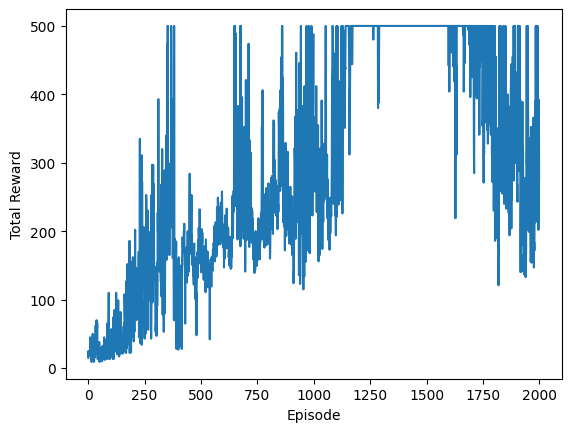

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [12]:
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(range(len(reward_history)), reward_history)
plt.show()

env.play()

### Chap 9.5. The Pros of Policy Gradient
- Policy Modeling
- Enable with Continous Action
- Smooth Action

### Chap 9.6. Summary

$ \nabla_{\theta}J(\theta) = E_{\tau  \tilde  \pi_{θ}}\bigg[\sum\limits_{t=0}^{T}\Phi_t\nabla_{\theta} log \pi_{\theta}(A_t|S_t) \bigg]$

- $\Phi_t = G(\tau)$ : Simple Policy Graident
- $\Phi_t = G_t$ : REINFORCE
- $\Phi_t = G_t - b(S_t)$ : REINFORCE with baseline
- $\Phi_t = R_t + \gamma V(S_{t+1}) - V(S_t)$ : Actor-Critic

- $\Phi_t = Q(S_t. A_t)$ : Q-function
- $\Phi_t = Q(S_t. A_t) - V(S_t) = A(S_t, A_t)$ : Advantage function